In [222]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

from datetime import datetime
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


Python(87618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


### Read data

Loading currency ruble rate frm 1992 till 2025

In [223]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/RC_F01_07_1992_T04_02_2025.csv", parse_dates=["date"])
data.columns = ["currency_rate", "date"]
data

,currency_rate,date
0,125.2600,1992-07-01
1,134.8000,1992-07-03
2,130.5000,1992-07-08
3,130.3000,1992-07-10
4,130.2000,1992-07-15
...,...,...
7514,97.9658,2025-01-29
7515,98.0126,2025-01-30
7516,98.0062,2025-01-31
7517,97.8107,2025-02-01


Loading newest 2025 data (Auguts 2025 which was lack of in data file above)

In [224]:
data_25 = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Rtsudcur.csv")
data_25

,#Date;Value 18:50 MSK
0,2025-08-22;80.7498
1,2025-08-21;80.2548
2,2025-08-20;80.1045
3,2025-08-19;80.3466
4,2025-08-18;80.4256
...,...
160,2025-01-10;101.9146
161,2025-01-09;102.2911
162,2025-01-08;101.6797
163,2025-01-06;101.6797


In [225]:
data_25[["date_25", "currency_rate_25"]] = data_25["#Date;Value 18:50 MSK"].str.split(";", expand=True)
data_25["date_25"] = pd.to_datetime(data_25["date_25"])
data_25["currency_rate_25"] = pd.to_numeric(data_25["currency_rate_25"])
data_25 = data_25.drop(columns=["#Date;Value 18:50 MSK"])

data_25

,date_25,currency_rate_25
0,2025-08-22,80.7498
1,2025-08-21,80.2548
2,2025-08-20,80.1045
3,2025-08-19,80.3466
4,2025-08-18,80.4256
...,...,...
160,2025-01-10,101.9146
161,2025-01-09,102.2911
162,2025-01-08,101.6797
163,2025-01-06,101.6797


In [226]:
merged_data = pd.merge(data, data_25, left_on="date", right_on="date_25", how="outer")
merged_data

,currency_rate,date,date_25,currency_rate_25
0,125.26,1992-07-01,NaT,NaN
1,134.80,1992-07-03,NaT,NaN
2,130.50,1992-07-08,NaT,NaN
3,130.30,1992-07-10,NaT,NaN
4,130.20,1992-07-15,NaT,NaN
...,...,...,...,...
7665,NaN,NaT,2025-08-18,80.4256
7666,NaN,NaT,2025-08-19,80.3466
7667,NaN,NaT,2025-08-20,80.1045
7668,NaN,NaT,2025-08-21,80.2548


In [227]:
merged_data["date"] = merged_data["date"].fillna(merged_data["date_25"])
merged_data["currency_rate"] = merged_data["currency_rate"].fillna(merged_data["currency_rate_25"])
merged_data = merged_data.drop(columns=["date_25", "currency_rate_25"])
data=merged_data
data

,currency_rate,date
0,125.2600,1992-07-01
1,134.8000,1992-07-03
2,130.5000,1992-07-08
3,130.3000,1992-07-10
4,130.2000,1992-07-15
...,...,...
7665,80.4256,2025-08-18
7666,80.3466,2025-08-19
7667,80.1045,2025-08-20
7668,80.2548,2025-08-21


In [228]:
data["year"] = data["date"].dt.year
data["quarter"] = data["date"].dt.quarter
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dow"] = data["date"].dt.dayofweek + 1
data["weekend"] = data["dow"].isin([6, 7])

data

,currency_rate,date,year,quarter,month,day,dow,weekend
0,125.2600,1992-07-01,1992,3,7,1,3,False
1,134.8000,1992-07-03,1992,3,7,3,5,False
2,130.5000,1992-07-08,1992,3,7,8,3,False
3,130.3000,1992-07-10,1992,3,7,10,5,False
4,130.2000,1992-07-15,1992,3,7,15,3,False
...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False
7666,80.3466,2025-08-19,2025,3,8,19,2,False
7667,80.1045,2025-08-20,2025,3,8,20,3,False
7668,80.2548,2025-08-21,2025,3,8,21,4,False


In [229]:
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend
7665,80.4256,2025-08-18,2025,3,8,18,1,False
7666,80.3466,2025-08-19,2025,3,8,19,2,False
7667,80.1045,2025-08-20,2025,3,8,20,3,False
7668,80.2548,2025-08-21,2025,3,8,21,4,False
7669,80.7498,2025-08-22,2025,3,8,22,5,False


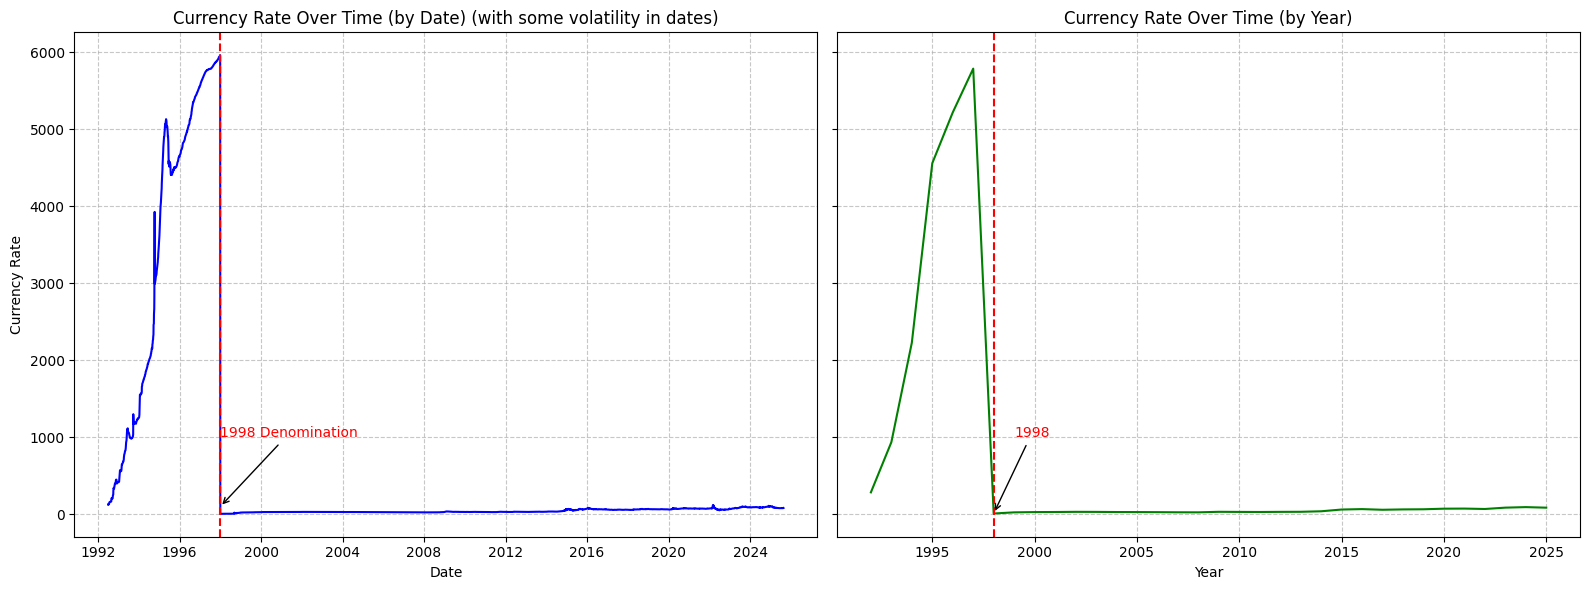

In [230]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="currency_rate", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)


denom_date = pd.to_datetime("1998-01-01")
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, 100), 
                xytext=(denom_date, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['currency_rate'].mean()
sns.lineplot(data=yearly, x="year", y="currency_rate", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)

# 1998
axs[1].axvline(1998, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998", 
                xy=(1998, yearly[yearly["year"] == 1998]["currency_rate"].values[0]),
                xytext=(1999, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [231]:
# calculate the daily percentage change in the currency rate
data['currency_rate_change'] = data['currency_rate'].pct_change() * 100

# find the date with the largest absolute percentage change
significant_change = data.loc[data['currency_rate_change'].abs().idxmax()]
significant_change_date = significant_change['date']
significant_change_value = significant_change['currency_rate_change']

significant_change_date, significant_change_value

(Timestamp('1998-01-01 00:00:00'), np.float64(-99.9))

In 1998, Russia carried out a currency reform that included a denomination and was preceded by a significant ruble devaluation.
Starting January 1, 1998, the government introduced a 1,000:1 denomination, replacing old banknotes with new ones to simplify the monetary system after a period of high inflation.


In [232]:
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change
794,5955.000,1997-12-25,1997,4,12,25,4,False,0.084034
795,5955.000,1997-12-26,1997,4,12,26,5,False,0.000000
796,5958.000,1997-12-27,1997,4,12,27,6,True,0.050378
797,5960.000,1997-12-30,1997,4,12,30,2,False,0.033568
798,5.960,1998-01-01,1998,1,1,1,4,False,-99.900000
799,5.963,1998-01-06,1998,1,1,6,2,False,0.050336
800,5.969,1998-01-07,1998,1,1,7,3,False,0.100620


In [233]:
# label data with pre and post denomination
data["denomination"] = np.where(data["date"] <= "1997-12-30", "pre", "post")

# normilize currency rate
data["RUB"] = np.where(data["denomination"] == "pre", data["currency_rate"]/1000, data["currency_rate"])
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB
794,5955.000,1997-12-25,1997,4,12,25,4,False,0.084034,pre,5.955
795,5955.000,1997-12-26,1997,4,12,26,5,False,0.000000,pre,5.955
796,5958.000,1997-12-27,1997,4,12,27,6,True,0.050378,pre,5.958
797,5960.000,1997-12-30,1997,4,12,30,2,False,0.033568,pre,5.960
798,5.960,1998-01-01,1998,1,1,1,4,False,-99.900000,post,5.960
799,5.963,1998-01-06,1998,1,1,6,2,False,0.050336,post,5.963
800,5.969,1998-01-07,1998,1,1,7,3,False,0.100620,post,5.969


After correcting and normalizing data plots looking better

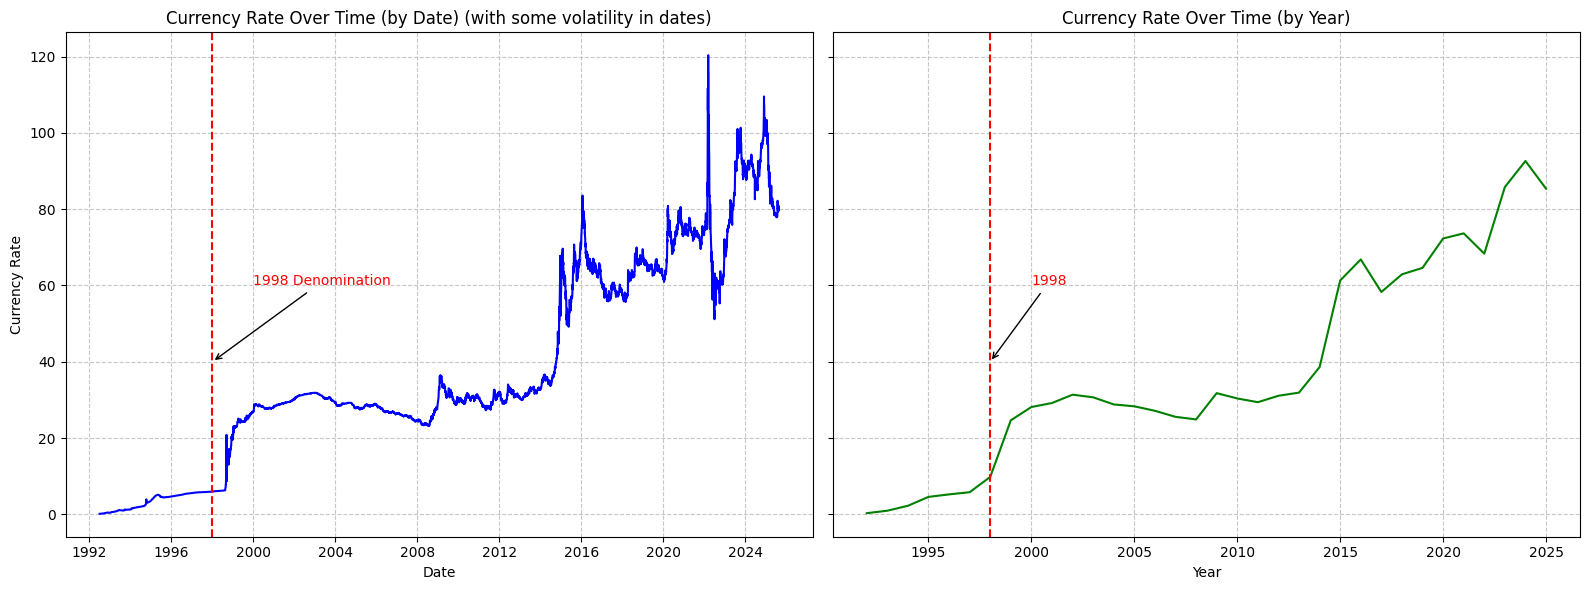

In [234]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Define the annotation point for both plots
denom_date = pd.to_datetime("1998-01-01")
arrow_y = 40
text_y = 60
text_x = pd.to_datetime("2000-01-01")

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="RUB", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)

# Add vertical line and arrow annotation
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, arrow_y), 
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['RUB'].mean()
sns.lineplot(data=yearly, x="year", y="RUB", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)

# Arrow coordinates for year-based plot
arrow_year = 1998
text_year = 2000

axs[1].axvline(arrow_year, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998", 
                xy=(arrow_year, arrow_y), 
                xytext=(text_year, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [235]:
data_year = data.groupby("year").agg({"RUB": "mean"}).reset_index()
data_year.head()

,year,RUB
0,1992,0.284345
1,1993,0.936061
2,1994,2.227129
3,1995,4.558707
4,1996,5.217653


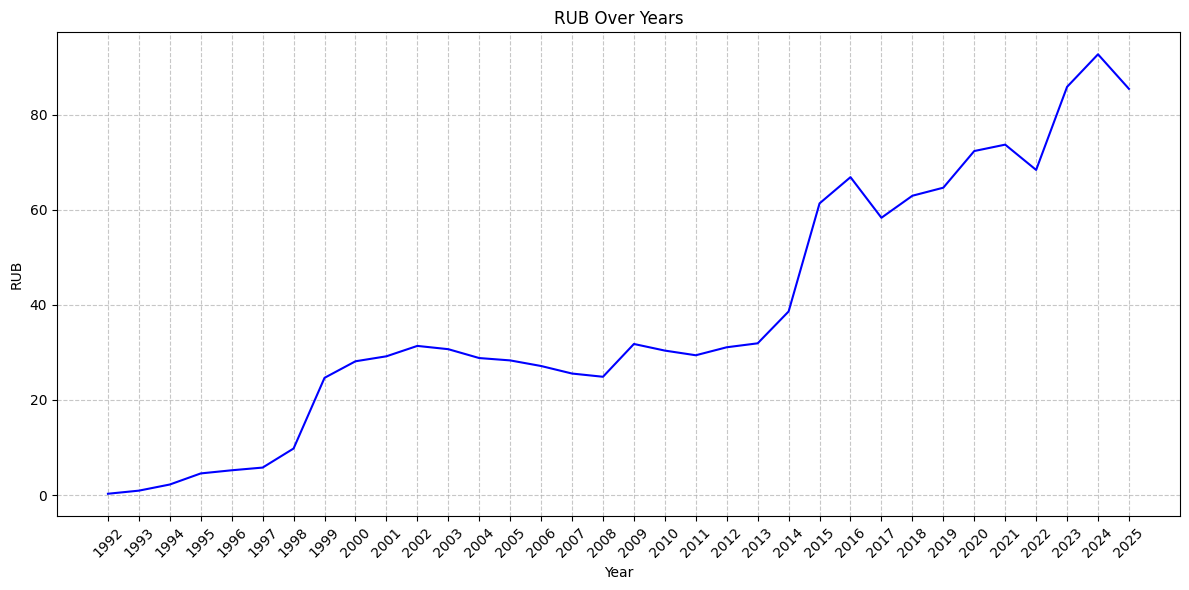

In [236]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_year, x="year", y="RUB", color="blue")

# Add labels and title
plt.xlabel("Year")
plt.ylabel("RUB")
plt.title("RUB Over Years")

# Set ticks explicitly to unique years
plt.xticks(ticks=data_year["year"], labels=data_year["year"], rotation=45)

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Overlay key economic and geopolitical shocks to highlight drivers of currency fluctuations

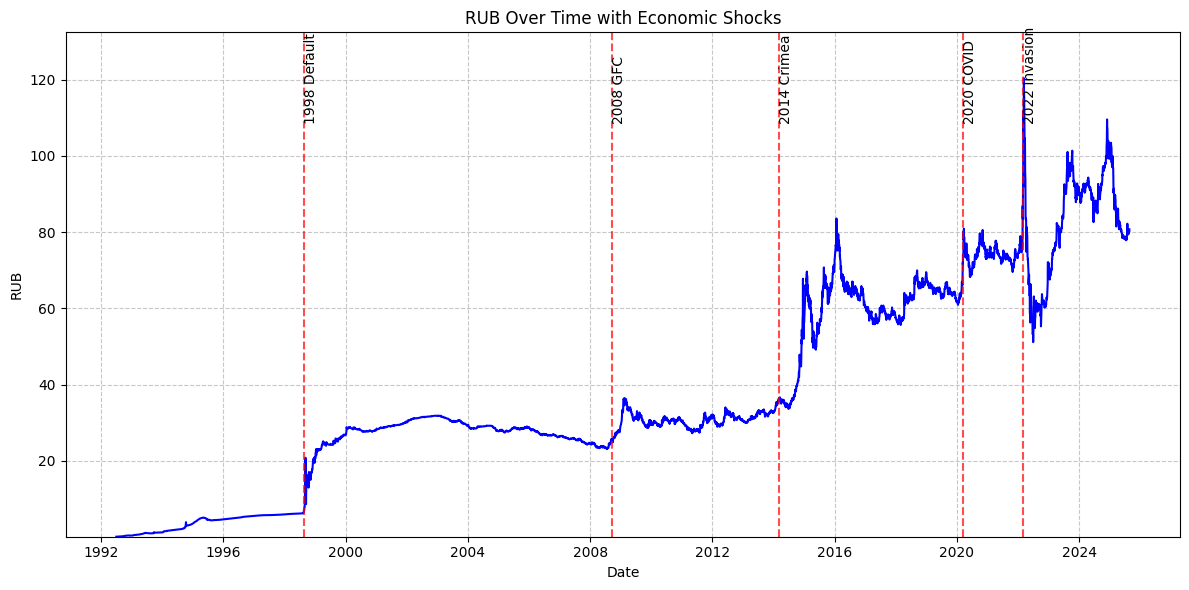

In [237]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="RUB", color="blue")

# Add vertical lines and labels for shocks
for label, date in shocks.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')

# Adjust y-axis limits to remove the gap
plt.ylim(data['RUB'].min() * 0.9, data['RUB'].max() * 1.1)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time with Economic Shocks")

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

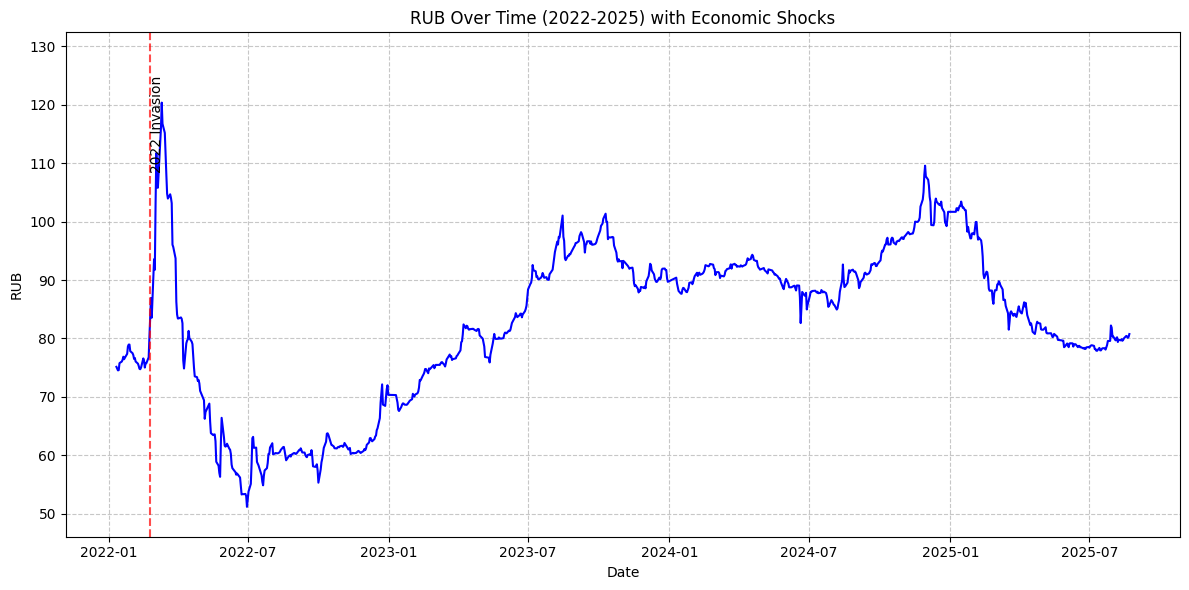

In [238]:
# Filter data for the years 2022 to 2025 to see how currency rate changed after 2022 Invasion
filtered_data = data[(data["year"] >= 2022) & (data["year"] <= 2025)]

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB", color="blue")

# Add vertical lines and labels for shocks within the filtered range
for label, date in shocks.items():
    shock_date = pd.to_datetime(date)
    if shock_date.year >= 2022 and shock_date.year <= 2025:
        plt.axvline(shock_date, color='red', linestyle='--', alpha=0.7)
        plt.text(shock_date, filtered_data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')

# Adjust y-axis limits to remove the gap
plt.ylim(filtered_data['RUB'].min() * 0.9, filtered_data['RUB'].max() * 1.1)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time (2022-2025) with Economic Shocks")

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [239]:
data.head()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB
0,125.26,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526
1,134.80,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480
2,130.50,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050
3,130.30,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030
4,130.20,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020


In [240]:
GDP_per_capita = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/GDP per capita (current US$).csv",skiprows=4)
GDP_deflator = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/GDP deflator (annual %).csv", skiprows=4)
FD_investment = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Foreign direct investment.csv", skiprows=4)
Inflation = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Inflation.csv", skiprows=4)
Brent_Crude_Oil = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/chart_20250912T211212.csv")
Metrcis_2025 = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/2025 Metrcis.csv")

In [241]:
GDP_per_capita_RUS = GDP_per_capita[GDP_per_capita["Country Code"] == "RUS"]

GDP_per_capita_RUS = GDP_per_capita_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_per_capita_RUS = GDP_per_capita_RUS.reset_index()
GDP_per_capita_RUS.columns = ["year", "GDP_per_capita"]
GDP_per_capita_RUS = GDP_per_capita_RUS[GDP_per_capita_RUS["year"].str.isdigit()]
GDP_per_capita_RUS = GDP_per_capita_RUS.dropna()


if 2025 not in GDP_per_capita_RUS["year"].astype(int).values:
    row_2025 = Metrcis_2025.loc[Metrcis_2025["Metric"] == "GDP_per_capita", ["year", "Value"]].rename(columns={"Value": "GDP_per_capita"})
    GDP_per_capita_RUS = pd.concat([GDP_per_capita_RUS, row_2025], ignore_index=True)
    GDP_per_capita_RUS["year"] = GDP_per_capita_RUS["year"].astype(int)
    GDP_per_capita_RUS = GDP_per_capita_RUS.sort_values("year").reset_index(drop=True)

GDP_per_capita_RUS.tail()

,year,GDP_per_capita
33,2021,12425.029297
34,2022,15619.614258
35,2023,14159.387695
36,2024,14889.018555
37,2025,14260.000000


In [242]:
GDP_deflator_RUS = GDP_deflator[GDP_deflator["Country Code"] == "RUS"]
GDP_deflator_RUS = GDP_deflator_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_deflator_RUS = GDP_deflator_RUS.reset_index()
GDP_deflator_RUS.columns = ["year", "GDP_deflator"]
GDP_deflator_RUS = GDP_deflator_RUS[GDP_deflator_RUS["year"].str.isdigit()]
GDP_deflator_RUS["year"] = GDP_deflator_RUS["year"].astype(int)


if 2025 not in GDP_deflator_RUS["year"].values:
    row_2025 = Metrcis_2025.loc[Metrcis_2025["Metric"] == "GDP_deflator", ["year", "Value"]].rename(columns={"Value": "GDP_deflator"})
    row_2025["year"] = row_2025["year"].astype(int)
    GDP_deflator_RUS = pd.concat([GDP_deflator_RUS, row_2025], ignore_index=True)
    GDP_deflator_RUS = GDP_deflator_RUS.sort_values("year").reset_index(drop=True)

GDP_deflator_RUS.tail()

,year,GDP_deflator
61,2021,18.209101
62,2022,18.184689
63,2023,7.998571
64,2024,9.275671
65,2025,8.200000


In [243]:
FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]
FD_investment_RUS = FD_investment_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
FD_investment_RUS = FD_investment_RUS.reset_index()
FD_investment_RUS.columns = ["year", "FD_investment"]
FD_investment_RUS = FD_investment_RUS[FD_investment_RUS["year"].str.isdigit()]
FD_investment_RUS = FD_investment_RUS.dropna()
FD_investment_RUS["year"] = FD_investment_RUS["year"].astype(int)

if 2025 not in FD_investment_RUS["year"].values:
    row_2025 = Metrcis_2025.loc[Metrcis_2025["Metric"] == "FD_investment", ["year", "Value"]].rename(columns={"Value": "FD_investment"})
    row_2025["year"] = row_2025["year"].astype(int)
    FD_investment_RUS = pd.concat([FD_investment_RUS, row_2025], ignore_index=True)
    FD_investment_RUS = FD_investment_RUS.sort_values("year").reset_index(drop=True)

FD_investment_RUS.tail()

,year,FD_investment
29,2021,4.045000e+10
30,2022,-3.980094e+10
31,2023,-1.004511e+10
32,2024,-8.175980e+09
33,2025,3.300000e+09


In [244]:
Inflation_RUS = Inflation[Inflation["Country Code"] == "RUS"]
Inflation_RUS = Inflation_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
Inflation_RUS = Inflation_RUS.reset_index()
Inflation_RUS.columns = ["year", "Inflation"]
Inflation_RUS = Inflation_RUS[Inflation_RUS["year"].str.isdigit()]
Inflation_RUS["year"] = Inflation_RUS["year"].astype(int)
Inflation_RUS = Inflation_RUS.dropna()

if 2025 not in Inflation_RUS["year"].values:
    row_2025 = Metrcis_2025.loc[Metrcis_2025["Metric"] == "Inflation", ["year", "Value"]].rename(columns={"Value": "Inflation"})
    row_2025["year"] = row_2025["year"].astype(int)
    Inflation_RUS = pd.concat([Inflation_RUS, row_2025], ignore_index=True)
    Inflation_RUS = Inflation_RUS.sort_values("year").reset_index(drop=True)

Inflation_RUS.tail()

,year,Inflation
31,2021,18.209101
32,2022,18.184689
33,2023,7.998571
34,2024,9.275671
35,2025,8.140000


In [245]:
Brent_Crude_Oil["year"] = pd.to_datetime(Brent_Crude_Oil["Date"]).dt.year
Brent_Crude_Oil["month"] = pd.to_datetime(Brent_Crude_Oil["Date"]).dt.month
Brent_Crude_Oil = Brent_Crude_Oil.rename(columns={'Value': 'Brent_price'})
Brent_Crude_Oil = Brent_Crude_Oil[Brent_Crude_Oil["year"]>1991]

Brent_Crude_Oil.tail()

,Date,Brent_price,year,month
456,05/30/2025,64.32,2025,5
457,06/30/2025,68.15,2025,6
458,07/31/2025,73.43,2025,7
459,08/29/2025,67.83,2025,8
460,09/08/2025,65.44,2025,9


In [246]:
GDP_per_capita_RUS["year"] = GDP_per_capita_RUS["year"].astype(int)

data = pd.merge(data, GDP_per_capita_RUS, on="year", how="left")
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.0
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.0
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.0
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.0
7669,80.7498,2025-08-22,2025,3,8,22,5,False,0.616786,post,80.7498,14260.0


In [247]:
Brent_Crude_Oil_merge = Brent_Crude_Oil[['year', 'month', 'Brent_price']].copy() 
data = pd.merge(data, Brent_Crude_Oil_merge, on=['year', 'month'], how='left')

In [248]:
GDP_deflator_RUS["year"] = GDP_deflator_RUS["year"].astype(int)
FD_investment_RUS["year"] = FD_investment_RUS["year"].astype(int)
Inflation_RUS["year"] = Inflation_RUS["year"].astype(int)
data = pd.merge(data, GDP_deflator_RUS, on="year", how="left")
data = pd.merge(data, FD_investment_RUS, on="year", how="left")
data = pd.merge(data, Inflation_RUS, on="year", how="left")

In [154]:
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.0,67.83,8.2,3.300000e+09,8.14
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.0,67.83,8.2,3.300000e+09,8.14
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.0,67.83,8.2,3.300000e+09,8.14
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.0,67.83,8.2,3.300000e+09,8.14
7669,80.7498,2025-08-22,2025,3,8,22,5,False,0.616786,post,80.7498,14260.0,67.83,8.2,3.300000e+09,8.14


In [157]:
daily_data = data
daily_data.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Daily_Data.csv", index=False)

In [249]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
monthly_data = data.resample('ME').agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[-1])
monthly_data = monthly_data.reset_index()
monthly_data.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv", index=False)
monthly_data.tail()


,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,83.243645,14260.0,63.37,8.2,3.300000e+09,8.14
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,80.237650,14260.0,64.32,8.2,3.300000e+09,8.14
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,78.677635,14260.0,68.15,8.2,3.300000e+09,8.14
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,78.850139,14260.0,73.43,8.2,3.300000e+09,8.14
397,2025-08-31,80.013656,2025.0,3.0,8.0,12.250000,3.125000,0.0,0.034674,post,80.013656,14260.0,67.83,8.2,3.300000e+09,8.14


In [67]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_deflator_x,GDP_per_capita,Brent_price,GDP_deflator_y,FD_investment,Inflation
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,1490.418425,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,1490.418425,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,1490.418425,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,1490.418425,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,1490.418425,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,8.200000,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,8.200000,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,8.200000,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,8.200000,14260.000000,67.83,8.200000,3.300000e+09,8.140000


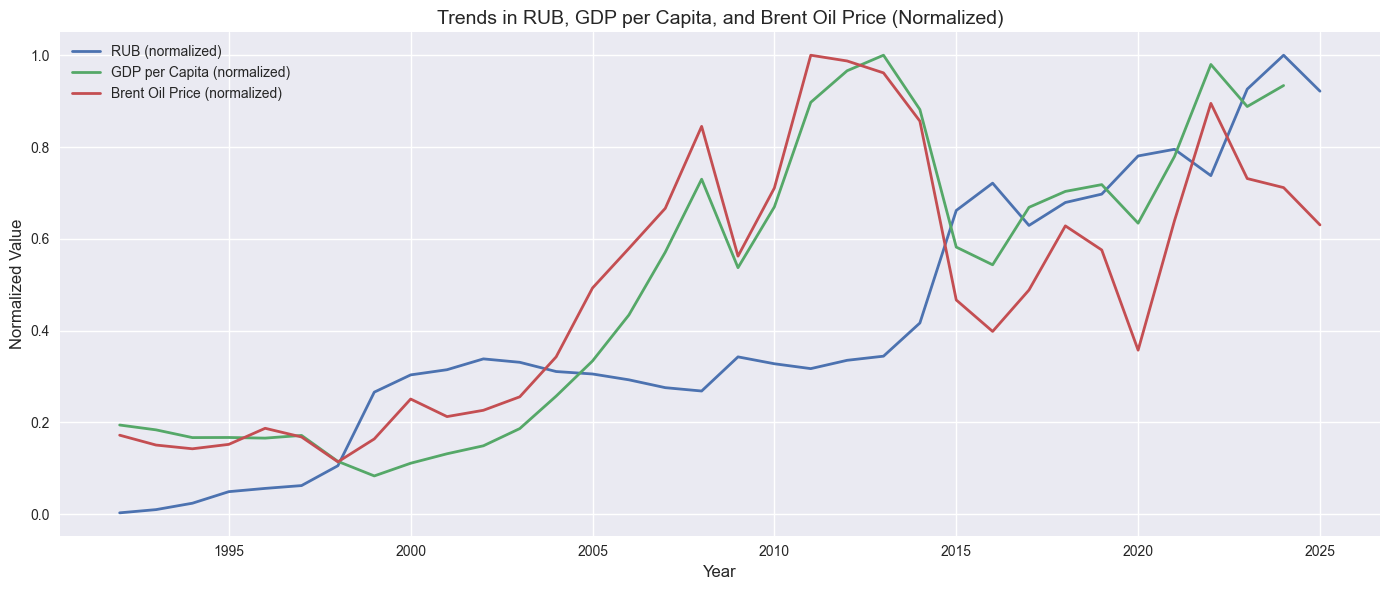

In [ ]:
annual_data = data.groupby("year").agg({
    "RUB": "mean",
    "GDP_per_capita": "mean",
    "Brent_price": "mean"
}).reset_index()


annual_data["RUB_norm"] = annual_data["RUB"] / annual_data["RUB"].max()
annual_data["GDP_norm"] = annual_data["GDP_per_capita"] / annual_data["GDP_per_capita"].max()
annual_data["Brent_norm"] = annual_data["Brent_price"] / annual_data["Brent_price"].max()

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB_norm"], label="RUB (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["GDP_norm"], label="GDP per Capita (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Brent_norm"], label="Brent Oil Price (normalized)", linewidth=2)

# Step 4: Format plot
plt.title("Trends in RUB, GDP per Capita, and Brent Oil Price (Normalized)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Checking stationarity

In [180]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.2938804992779482
p-value: 0.631967321492641
Critical Values: {'1%': np.float64(-3.431206441353405), '5%': np.float64(-2.8619184832442954), '10%': np.float64(-2.56697146213229)}


In [24]:
data["RUB_diff"] = data["RUB"].diff().dropna()

result = adfuller(data["RUB_diff"].dropna())
print("ADF Statistic (1st diff):", result[0])
print("p-value:", result[1])

ADF Statistic (1st diff): -15.06612858554876
p-value: 8.86028697354434e-28


### ARIMA with 1, 1, 1 without train/test and CV - ARIMA Test

In [26]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,0.00954
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,-0.00430
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,-0.00020
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,-0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,0.40320
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,-0.07900
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,-0.24210
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,0.15030


In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA with (p=1, d=1, q=1) as a starting point
model = ARIMA(data["RUB"], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 7670
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6882.992
Date:                Mon, 25 Aug 2025   AIC                          13771.985
Time:                        03:51:13   BIC                          13792.820
Sample:                             0   HQIC                         13779.131
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.015     42.836      0.000       0.629       0.689
ma.L1         -0.5769      0.017    -33.699      0.000      -0.610      -0.543
sigma2         0.3524      0.001    318.998      0.0

In [37]:
from pmdarima import auto_arima

In [ ]:
# Run auto_arima
model = auto_arima(data["RUB"], 
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=None,              # Let auto_arima determine d
                   seasonal=False,      # Currency is usually non-seasonal
                   stepwise=True,       # Faster search
                   trace=True)          # Show search process

# Summary of best model
print(model.summary())

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-package

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13858.385, Time=0.61 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13780.379, Time=0.35 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13781.715, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13858.762, Time=0.10 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13781.784, Time=0.35 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13772.414, Time=1.66 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13767.177, Time=3.66 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13755.703, Time=3.40 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13760.042, Time=0.60 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13757.556, Time=6.45 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13757.170, Time=4.94 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13758.652, Time=4.56 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13759.708, Time=0.78 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13759.078, Time=7.36 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13755.236, Time=1.23 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13766.708, Time=1.34 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,0)(0,0,0)[0]             : AIC=13759.747, Time=0.32 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=13757.086, Time=2.60 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=13756.704, Time=1.96 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13781.690, Time=0.21 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13758.172, Time=2.06 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,0)(0,0,0)[0]             : AIC=13759.355, Time=0.75 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=13758.606, Time=3.91 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 49.828 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7670
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6872.618
Date:                Mon, 25 Aug 2025   AIC                          13755.236
Time:                        02:59:25   BIC                          13789.960
Sample:                             0   HQIC                         13767.147
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6063      0.034     18.046      0.000       0.54

### Splitting Data fro Prediction

In [28]:
data_post_default = data[data["year"] >= 1998]
data_post_default

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
798,5.9600,1998-01-01,1998,1,1,1,4,False,-99.900000,post,5.9600,0.0000
799,5.9630,1998-01-06,1998,1,1,6,2,False,0.050336,post,5.9630,0.0030
800,5.9690,1998-01-07,1998,1,1,7,3,False,0.100620,post,5.9690,0.0060
801,5.9720,1998-01-09,1998,1,1,9,5,False,0.050260,post,5.9720,0.0030
802,5.9740,1998-01-10,1998,1,1,10,6,True,0.033490,post,5.9740,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,0.4032
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,-0.0790
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,-0.2421
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,0.1503


In [29]:
data["year"].value_counts().sort_index()

year
1992     53
1993     99
1994    101
1995     99
1996    196
1997    250
1998    251
1999    250
2000    251
2001    249
2002    250
2003    250
2004    251
2005    248
2006    248
2007    249
2008    249
2009    249
2010    249
2011    249
2012    249
2013    246
2014    247
2015    247
2016    248
2017    247
2018    247
2019    246
2020    243
2021    248
2022    247
2023    247
2024    248
2025    169
Name: count, dtype: int64

In [30]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2025, :]
data_work = data.loc[lambda x: x["year"] < 2025, :]

### Balanced CV with 13 recent years

In [31]:
# Start from 2005 + 13 = 2018 (to ensure 13 full years of training)
for year in range(2018, 2025):  # 2025 reserved for holdout
    fold = year - 2018  # fold0 corresponds to year=2018
    data_work[f"train{fold}"] = (data_work["year"] >= year - 13) & (data_work["year"] <= year - 1)
    data_work[f"test{fold}"] = data_work["year"] == year

# Define holdout (2025)
data_work["holdout"] = data_work["year"] == 2025

/tmp/ipykernel_59559/3847985813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_59559/3847985813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_59559/3847985813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_59559/3

In [32]:
data_work

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,...,test2,train3,test3,train4,test4,train5,test5,train6,test6,holdout
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,...,False,False,False,False,False,False,False,False,False,False
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,...,False,False,False,False,False,False,False,False,False,False
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,...,False,False,False,False,False,False,False,False,False,False
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,...,False,False,False,False,False,False,False,False,False,False
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,99.8729,2024-12-25,2024,4,12,25,3,False,-1.713735,post,...,False,False,False,False,False,False,False,False,True,False
7497,99.6125,2024-12-26,2024,4,12,26,4,False,-0.260731,post,...,False,False,False,False,False,False,False,False,True,False
7498,99.2295,2024-12-27,2024,4,12,27,5,False,-0.384490,post,...,False,False,False,False,False,False,False,False,True,False
7499,100.5281,2024-12-28,2024,4,12,28,6,True,1.308683,post,...,False,False,False,False,False,False,False,False,True,False


In [35]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

In [57]:
# 1. Run auto_arima to determine best ARIMA(p,d,q)
auto_model = auto_arima(
    data_work.RUB,
    max_p=2, 
    max_q=2,
    seasonal=False,
    m=7,  # try 7 and 30 both — test which performs better
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# 2. Extract best order (p, d, q)
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds
mse_2 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Fit model on training data
    model = ARIMA(endog=y_train, order=best_order).fit()

    # Forecast exactly len(test) steps
    n_steps = len(y_test)
    phat = model.forecast(steps=n_steps)

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

/usr/local/python/3.12.1/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWa

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13334.519, Time=4.69 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13427.443, Time=0.35 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13356.033, Time=0.53 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13358.027, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13429.364, Time=0.10 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13340.660, Time=3.16 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13341.402, Time=3.10 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13344.285, Time=1.66 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13335.035, Time=2.40 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 16.513 seconds
Best ARIMA order: (2, 1, 2)


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

CV RMSE (Auto ARIMA): 9.75930400817721


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


In [121]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 3215
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -2869.002
Date:                Mon, 25 Aug 2025   AIC                           5748.005
Time:                        03:04:10   BIC                           5778.381
Sample:                             0   HQIC                          5758.893
                               - 3215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7480      0.703      1.064      0.287      -0.630       2.126
ma.L1         -0.7896      0.702     -1.124      0.261      -2.166       0.587
ma.L2          0.0614      0.031      2.006      0.0

In [ ]:
# 1. Fit final model on full data
model_final = ARIMA(data_work.RUB, order=(2, 1, 2)).fit()

# 2. Forecast for 2025
n_steps = data_holdout.shape[0]  # Get number of periods in 2025
pred_final = model_final.get_forecast(steps=n_steps)

# 3. Extract forecast results and fix index to match data_holdout
pred_mean = pred_final.predicted_mean
conf_int = pred_final.conf_int(alpha=0.2)
conf_int.index = data_holdout.index  # This line ensures indexes align

# 4. Combine everything into one DataFrame
forecast_holdout_best = pd.concat([
    data_holdout.reset_index(drop=True),
    pred_mean.rename("RUB_pred").reset_index(drop=True),
    conf_int.reset_index(drop=True).rename(columns={
        conf_int.columns[0]: "lower RUB",
        conf_int.columns[1]: "upper RUB"
    }),
], axis=1)

# 5. Final plot-ready data
#data_plot = forecast_holdout_best[[
#     "date", "currency_rate", "currency_rate_pred", "lower currency_rate", "upper currency_rate"
#]]

In [40]:
forecast_holdout_best["residuals"] = forecast_holdout_best["RUB"] - forecast_holdout_best["RUB_pred"]
forecast_holdout_best

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff,RUB_pred,lower RUB,upper RUB,residuals
0,101.6797,2025-01-03,2025,1,1,3,5,False,0.000000,post,101.6797,0.0000,101.750808,100.996942,102.504673,-0.071108
1,101.6797,2025-01-06,2025,1,1,6,1,False,0.000000,post,101.6797,0.0000,101.799013,100.678248,102.919778,-0.119313
2,101.6797,2025-01-08,2025,1,1,8,3,False,0.000000,post,101.6797,0.0000,101.837943,100.433708,103.242177,-0.158243
3,102.2911,2025-01-09,2025,1,1,9,4,False,0.601300,post,102.2911,0.6114,101.865745,100.208790,103.522700,0.425355
4,102.2911,2025-01-10,2025,1,1,10,5,False,0.000000,post,102.2911,0.0000,101.887376,100.004765,103.769988,0.403724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,0.4032,101.951571,89.780800,114.122341,-21.525971
165,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,-0.0790,101.951571,89.743652,114.159489,-21.604971
166,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,-0.2421,101.951571,89.706616,114.196526,-21.847071
167,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,0.1503,101.951571,89.669691,114.233450,-21.696771


In [41]:
forecast_holdout_best[['date', 'month','RUB', 'RUB_pred', 'residuals']]

,date,month,RUB,RUB_pred,residuals
0,2025-01-03,1,101.6797,101.750808,-0.071108
1,2025-01-06,1,101.6797,101.799013,-0.119313
2,2025-01-08,1,101.6797,101.837943,-0.158243
3,2025-01-09,1,102.2911,101.865745,0.425355
4,2025-01-10,1,102.2911,101.887376,0.403724
...,...,...,...,...,...
164,2025-08-18,8,80.4256,101.951571,-21.525971
165,2025-08-19,8,80.3466,101.951571,-21.604971
166,2025-08-20,8,80.1045,101.951571,-21.847071
167,2025-08-21,8,80.2548,101.951571,-21.696771


In [54]:
forecast_holdout_best[forecast_holdout_best['month'] == 1]

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff,RUB_pred,lower RUB,upper RUB,residuals
0,101.6797,2025-01-03,2025,1,1,3,5,False,0.000000,post,101.6797,0.0000,101.750808,100.996942,102.504673,-0.071108
1,101.6797,2025-01-06,2025,1,1,6,1,False,0.000000,post,101.6797,0.0000,101.799013,100.678248,102.919778,-0.119313
2,101.6797,2025-01-08,2025,1,1,8,3,False,0.000000,post,101.6797,0.0000,101.837943,100.433708,103.242177,-0.158243
3,102.2911,2025-01-09,2025,1,1,9,4,False,0.601300,post,102.2911,0.6114,101.865745,100.208790,103.522700,0.425355
4,102.2911,2025-01-10,2025,1,1,10,5,False,0.000000,post,102.2911,0.0000,101.887376,100.004765,103.769988,0.403724
5,101.9146,2025-01-11,2025,1,1,11,6,True,-0.368067,post,101.9146,-0.3765,101.903226,99.812156,103.994296,0.011374
6,102.7081,2025-01-13,2025,1,1,13,1,False,0.778593,post,102.7081,0.7935,101.915336,99.631060,104.199613,0.792764
7,102.7081,2025-01-14,2025,1,1,14,2,False,0.000000,post,102.7081,0.0000,101.924322,99.458738,104.389906,0.783778
8,103.4380,2025-01-15,2025,1,1,15,3,False,0.710655,post,103.4380,0.7299,101.931127,99.294706,104.567548,1.506873
9,102.8078,2025-01-16,2025,1,1,16,4,False,-0.609254,post,102.8078,-0.6302,101.936208,99.137811,104.734604,0.871592


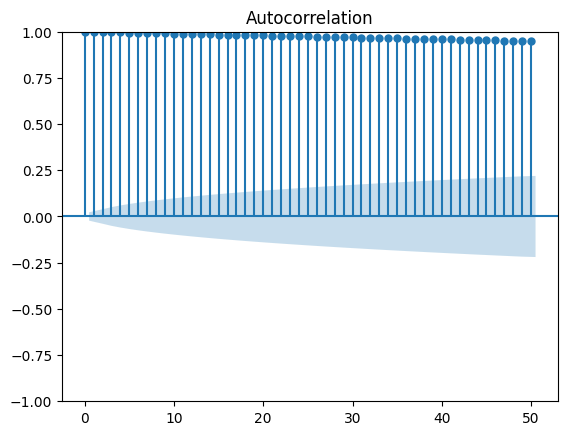

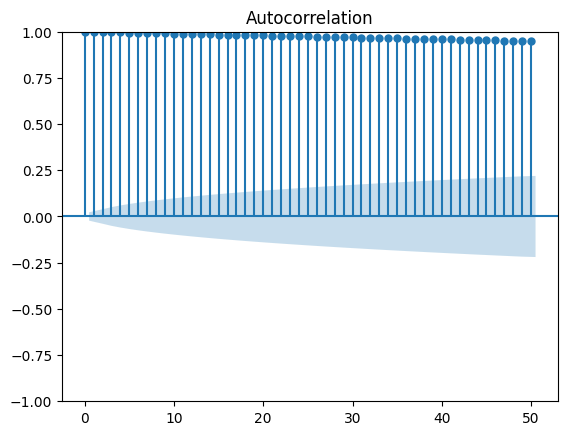

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_work.RUB, lags=50)

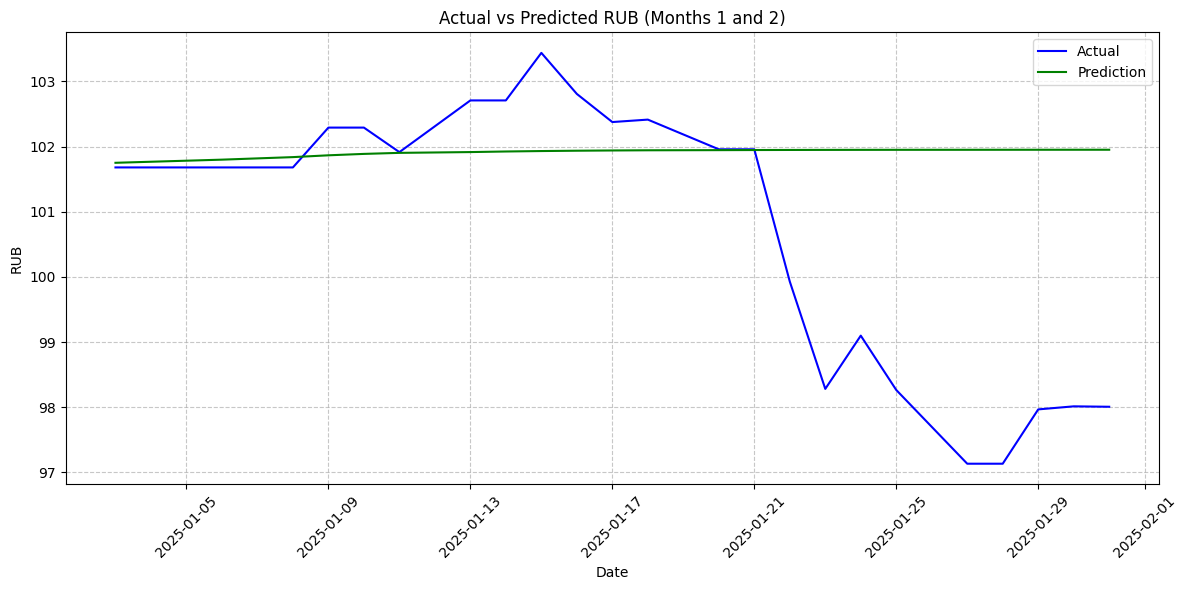

In [53]:
# Filter the data for rows where predictions are not null and months are 1 or 2
filtered_data = forecast_holdout_best[(forecast_holdout_best['month'].isin([1]))][['date', 'RUB', 'RUB_pred', 'residuals']]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB", label="Actual", color="blue")
sns.lineplot(data=filtered_data, x="date", y="RUB_pred", label="Prediction", color="green")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("Actual vs Predicted RUB (Months 1 and 2)")

# Format the x-axis for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

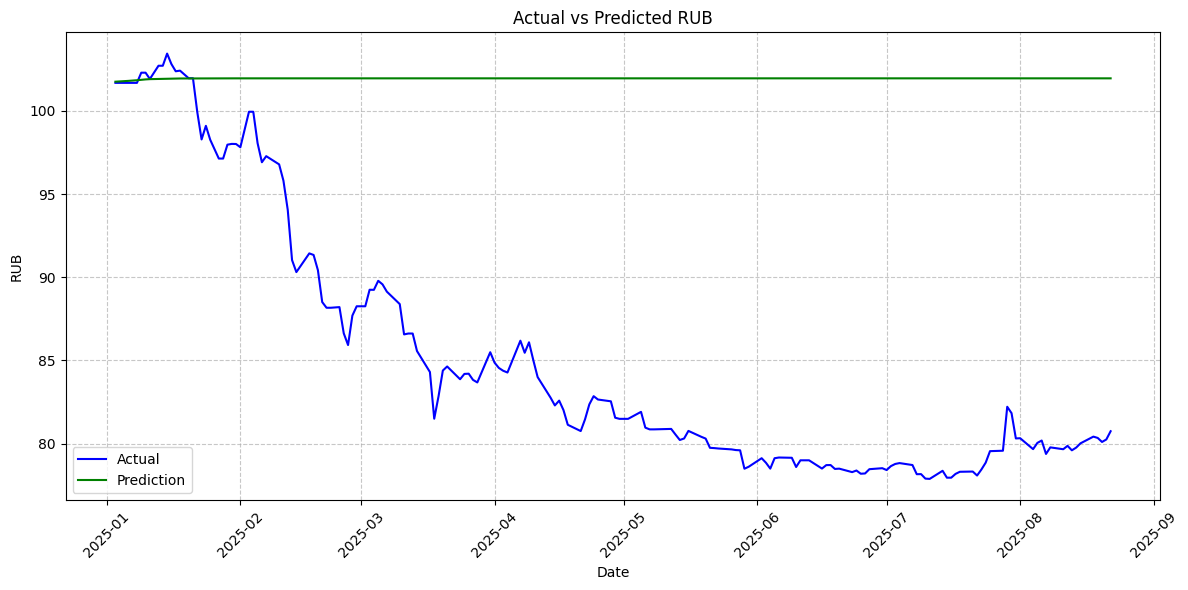

In [50]:
# Filter the data for rows where predictions are not null
filtered_data = forecast_holdout_best[['date', 'RUB', 'RUB_pred', 'residuals']]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB", label="Actual", color="blue")
sns.lineplot(data=filtered_data, x="date", y="RUB_pred", label="Prediction", color="green")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("Actual vs Predicted RUB")

# Format the x-axis for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [132]:
forecast_holdout_best["residuals"].describe()

count    169.000000
mean     -16.615908
std        7.816218
min      -24.132128
25%      -22.439428
50%      -19.997628
75%      -13.507328
max        1.426320
Name: residuals, dtype: float64

In [133]:
# Ensure date column exists and is aligned in both
forecast_holdout_best = forecast_holdout_best.reset_index()  # if date is in index
data_reset = data.reset_index()  # same here

# Merge by date column (you can use 'year' or 'date' depending on what you have)
data_plot = (
    data_reset
    .merge(forecast_holdout_best, on="date", how="left")
    .loc[lambda x: x.date.dt.year >= 2015]
    .reset_index(drop=True)
)

data_plot

,index_x,currency_rate_x,date,year_x,quarter_x,month_x,day_x,dow_x,weekend_x,currency_rate_change_x,...,dow_y,weekend_y,currency_rate_change_y,denomination_y,RUB_y,RUB_diff_y,RUB_pred,lower RUB,upper RUB,residuals
0,5033,56.2376,2015-01-01,2015,1,1,1,4,False,-0.036972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5034,62.7363,2015-01-13,2015,1,1,13,2,False,11.555792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5035,64.8425,2015-01-14,2015,1,1,14,3,False,3.357227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5036,66.0983,2015-01-15,2015,1,1,15,4,False,1.936693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5037,64.8337,2015-01-16,2015,1,1,16,5,False,-1.913211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,...,1.0,False,0.503859,post,80.4256,0.4032,102.017628,89.960653,114.074602,-21.592028
2633,7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,...,2.0,False,-0.098227,post,80.3466,-0.0790,102.017628,89.923923,114.111333,-21.671028
2634,7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,...,3.0,False,-0.301320,post,80.1045,-0.2421,102.017628,89.887304,114.147952,-21.913128
2635,7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,...,4.0,False,0.187630,post,80.2548,0.1503,102.017628,89.850795,114.184460,-21.762828


In [135]:
data_plot.columns

Index(['index_x', 'currency_rate_x', 'date', 'year_x', 'quarter_x', 'month_x',
       'day_x', 'dow_x', 'weekend_x', 'currency_rate_change_x',
       'denomination_x', 'RUB_x', 'RUB_diff_x', 'level_0', 'index_y',
       'currency_rate_y', 'year_y', 'quarter_y', 'month_y', 'day_y', 'dow_y',
       'weekend_y', 'currency_rate_change_y', 'denomination_y', 'RUB_y',
       'RUB_diff_y', 'RUB_pred', 'lower RUB', 'upper RUB', 'residuals'],
      dtype='object')

In [136]:
data_plot[data_plot["RUB_x"].notnull()][["date", "RUB_x", "RUB_pred"]]

,date,RUB_x,RUB_pred
0,2015-01-01,56.2376,NaN
1,2015-01-13,62.7363,NaN
2,2015-01-14,64.8425,NaN
3,2015-01-15,66.0983,NaN
4,2015-01-16,64.8337,NaN
...,...,...,...
2632,2025-08-18,80.4256,102.017628
2633,2025-08-19,80.3466,102.017628
2634,2025-08-20,80.1045,102.017628
2635,2025-08-21,80.2548,102.017628


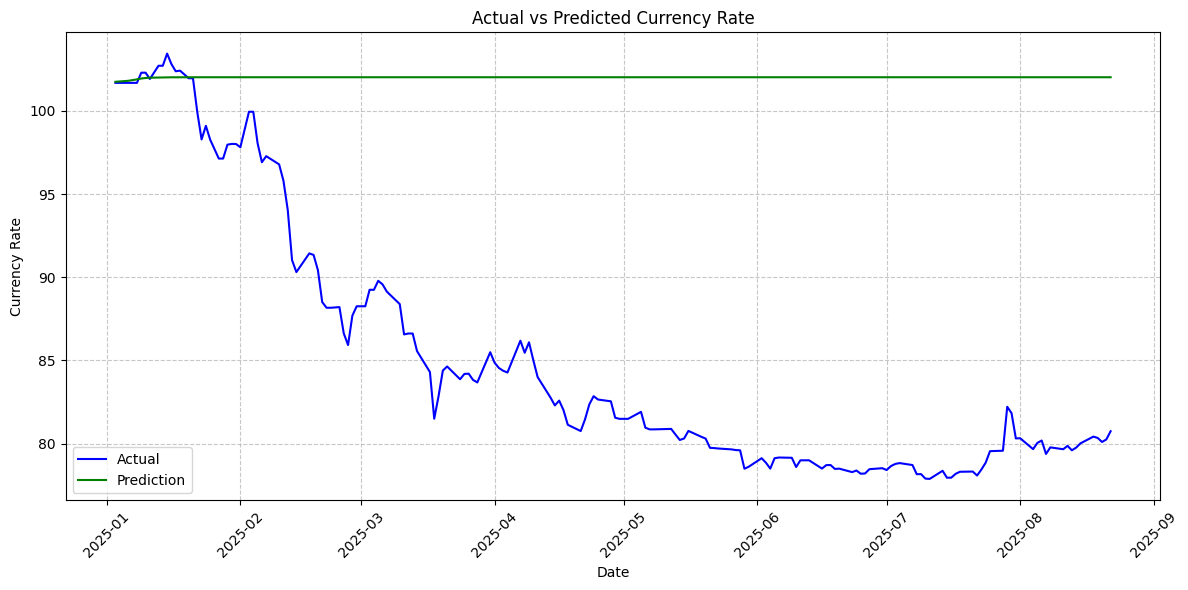

In [137]:
# Filter the data for rows where predictions are not null
filtered_data = data_plot[data_plot["RUB_pred"].notnull()][["date", "RUB_x", "RUB_pred"]]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB_x", label="Actual", color="blue")
sns.lineplot(data=filtered_data, x="date", y="RUB_pred", label="Prediction", color="green")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Currency Rate")
plt.title("Actual vs Predicted Currency Rate")

# Format the x-axis for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

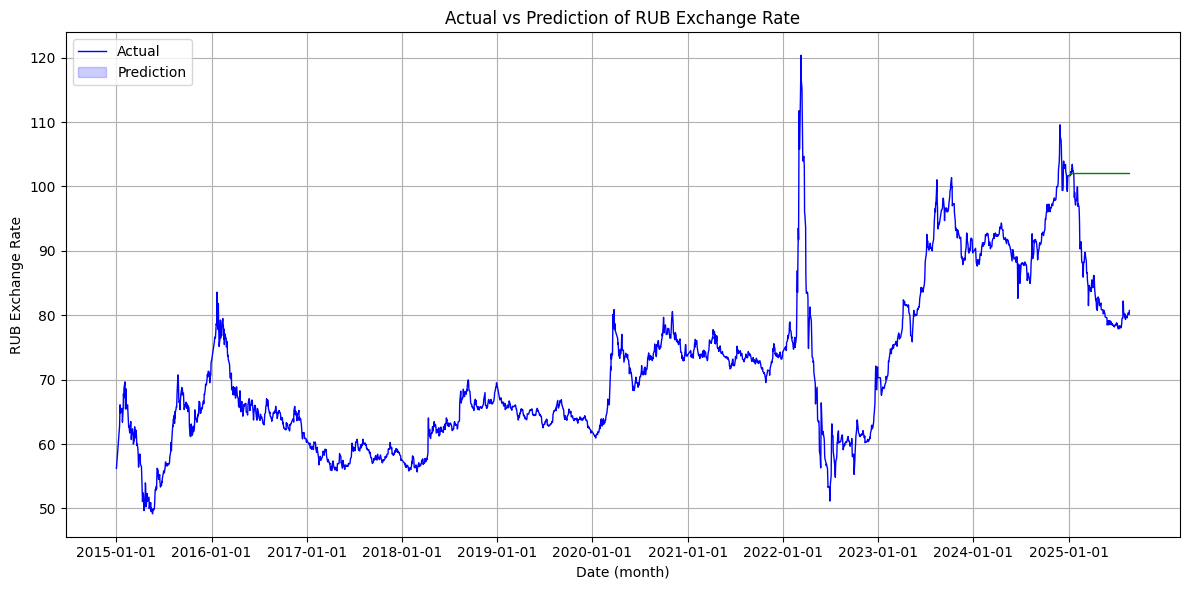

In [138]:
# Melt the data for plotting
data_plot_1 = pd.melt(data_plot.filter(["date", "RUB_x", "RUB_pred"]), ["date"])

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_plot_1, x="date", y="value", hue="variable", linewidth=1, palette={"RUB_x": "blue", "RUB_pred": "green"})

# Add labels and title
plt.ylabel("RUB Exchange Rate")
plt.xlabel("Date (month)")
plt.title("Actual vs Prediction of RUB Exchange Rate")

# Customize legend
plt.legend(title="", labels=["Actual", "Prediction"], loc="upper left")

# Format x-axis for better readability
plt.xticks(pd.date_range(start=data_plot_1["date"].min(), end=data_plot_1["date"].max(), freq="1YS"))

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [99]:
data_plot_1[data_plot_1["date"]=='2025-08-18']

,date,variable,value
2632,2025-08-18,currency_rate_change_x,0.503859
5269,2025-08-18,currency_rate_pred,101.679700


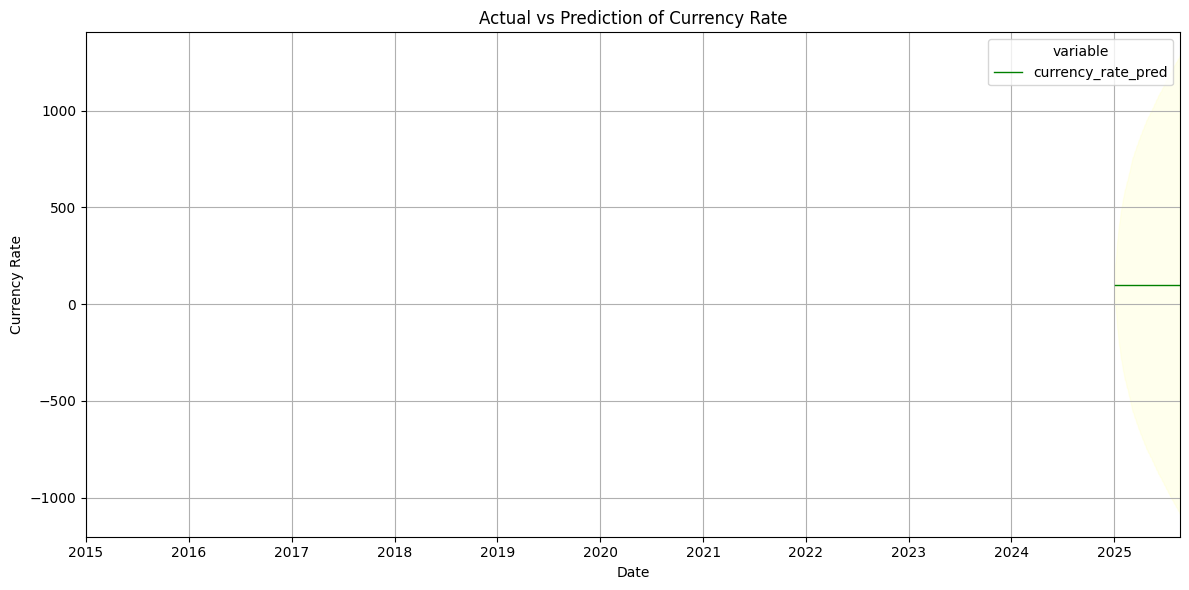

In [ ]:
# Reshape the data for plotting
data_plot_melted = pd.melt(
    data_plot.filter(["date", "Actual", "Prediction"]),
    id_vars=["date"],
    var_name="variable",
    value_name="value"
)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual and predicted values
sns.lineplot(data=data_plot_melted, x="date", y="value", hue="variable", linewidth=1, 
             palette={"currency_rate": "blue", "currency_rate_pred": "green"})

# Add confidence interval as a shaded area using the original data_plot DataFrame
plt.fill_between(
    data_plot["date"],
    data_plot["lower currency_rate"],
    data_plot["upper currency_rate"],
    color="#FFFFC5",
    alpha=0.3,
    label="Confidence Interval"
)

# Add labels and title
plt.ylabel("Currency Rate")
plt.xlabel("Date")
plt.title("Actual vs Prediction of Currency Rate")

# Set x-axis limits to show all dates
plt.xlim(data_plot["date"].min(), data_plot["date"].max())

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


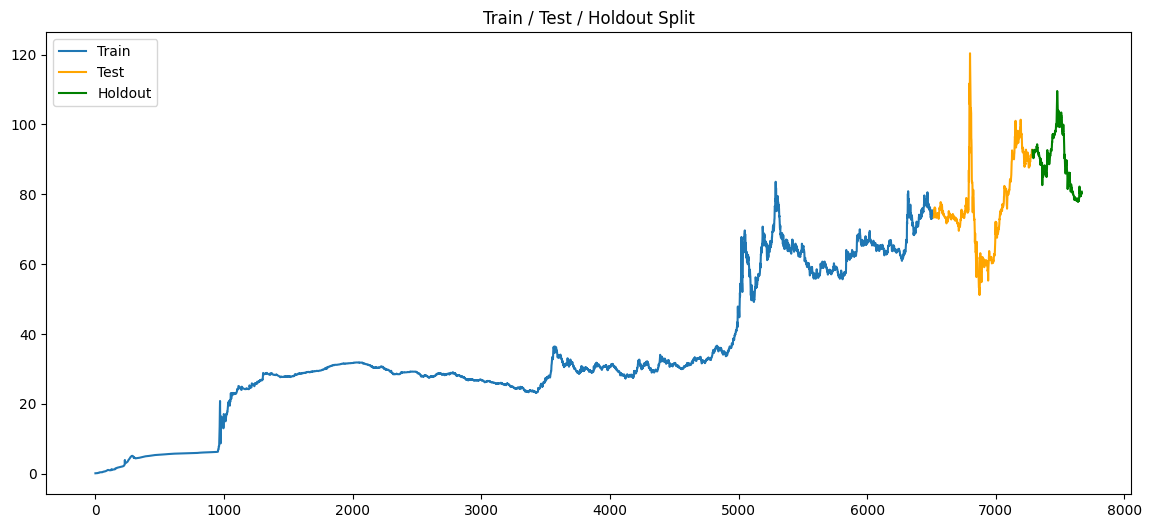

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train.index, train["RUB"], label="Train")
plt.plot(test.index, test["RUB"], label="Test", color="orange")
plt.plot(holdout.index, holdout["RUB"], label="Holdout", color="green")
plt.title("Train / Test / Holdout Split")
plt.legend()
plt.show()

In [ ]:
# 1. Run auto_arima to determine best ARIMA(p,d,q)
auto_model = auto_arima(
    train.p,
    start_p=0,
    max_p=1,  # AR = 1; Without this constrain, python returns other ARIMA order
    max_order=0, # p + q + P + Q <= 0
    seasonal=False,
)

# 2. Extract best order (p, d, q)
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds
mse_0 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "p"].sort_index()
    y_test  = data_work.loc[test_mask,  "p"].sort_index()

    # Fit model on training data
    model = ARIMA(endog=y_train, order=best_order).fit()

    # Forecast exactly len(test) steps
    phat = model.forecast(steps=12)

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

In [17]:
!pip install wbdata

In [20]:
country = "RUS"
indicators = {
    'NY.GDP.MKTP.CD': 'GDP (current US$)',
    'FP.CPI.TOTL.ZG': 'Inflation (CPI %)',
    'BX.KLT.DINV.CD.WD': 'FDI (net inflows)'
}

start_date = datetime.datetime(1992, 7, 1)
end_date = datetime.datetime(2025, 8, 22)


In [110]:
GDP_per_capita = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP per capita (current US$).csv",skiprows=4)
GDP_deflator = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP deflator (annual %).csv", skiprows=4)
FD_investment = pd.read_csv("/workspaces/codespaces-jupyter/data/Foreign direct investment.csv", skiprows=4)

In [22]:
GDP_per_capita_RUS = GDP_per_capita[GDP_per_capita["Country Code"] == "RUS"]

GDP_per_capita_RUS = GDP_per_capita_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_per_capita_RUS = GDP_per_capita_RUS.reset_index()
GDP_per_capita_RUS.columns = ["year", "GDP_per_capita"]
GDP_per_capita_RUS = GDP_per_capita_RUS[GDP_per_capita_RUS["year"].str.isdigit()]

GDP_per_capita_RUS

,year,GDP_per_capita
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,10108.327148
61,2021,12425.029297
62,2022,15619.614258
63,2023,14159.387695


In [31]:
GDP_deflator_RUS = GDP_deflator[GDP_deflator["Country Code"] == "RUS"]

GDP_deflator_RUS = GDP_deflator_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_deflator_RUS = GDP_deflator_RUS.reset_index()
GDP_deflator_RUS.columns = ["year", "GDP_deflator"]
GDP_deflator_RUS = GDP_deflator_RUS[GDP_deflator_RUS["year"].str.isdigit()]

GDP_deflator_RUS

,year,GDP_deflator
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,0.898246
61,2021,18.209101
62,2022,18.184689
63,2023,7.998571


In [32]:
FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]

FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]
FD_investment_RUS = FD_investment_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
FD_investment_RUS = FD_investment_RUS.reset_index()
FD_investment_RUS.columns = ["year", "FD_investment"]
FD_investment_RUS = FD_investment_RUS[FD_investment_RUS["year"].str.isdigit()]

FD_investment_RUS

,year,FD_investment
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,9.478810e+09
61,2021,4.045000e+10
62,2022,-3.980094e+10
63,2023,-1.004511e+10


/tmp/ipykernel_39130/30258625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


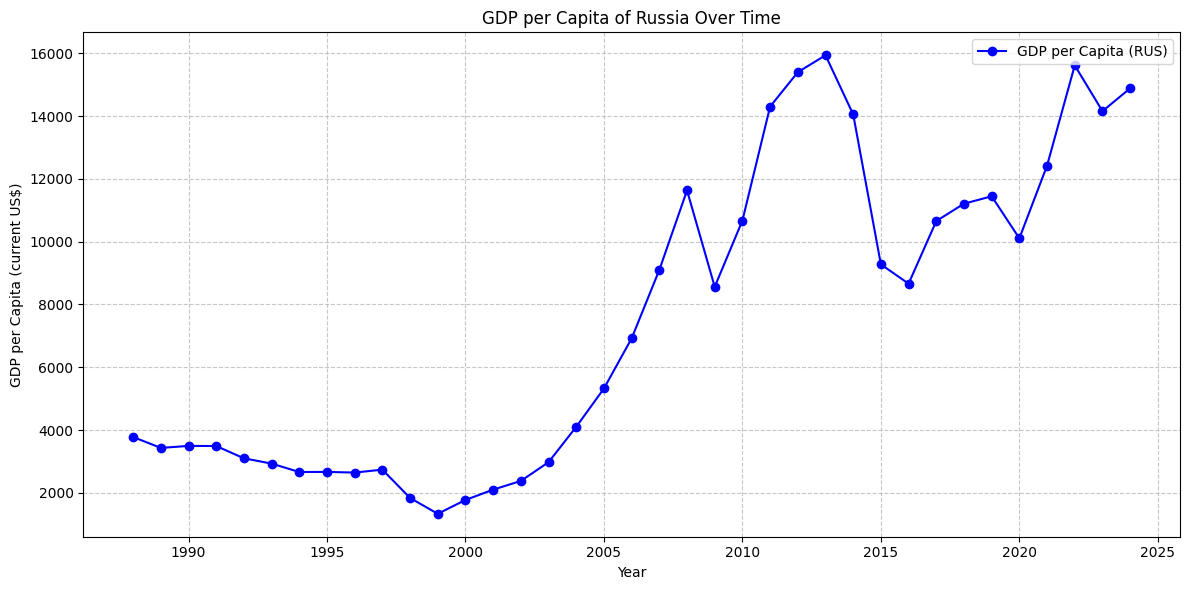

In [ ]:
GDP_per_capita_RUS_cleaned = GDP_per_capita_RUS.dropna(subset=["GDP_per_capita"])

# Convert the 'year' column to integer for plotting
GDP_per_capita_RUS_cleaned["year"] = GDP_per_capita_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    GDP_per_capita_RUS_cleaned["year"],
    GDP_per_capita_RUS_cleaned["GDP_per_capita"],
    marker="o",
    linestyle="-",
    color="blue",
    label="GDP per Capita (RUS)"
)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("GDP per Capita (current US$)")
plt.title("GDP per Capita of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_39130/1164168808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


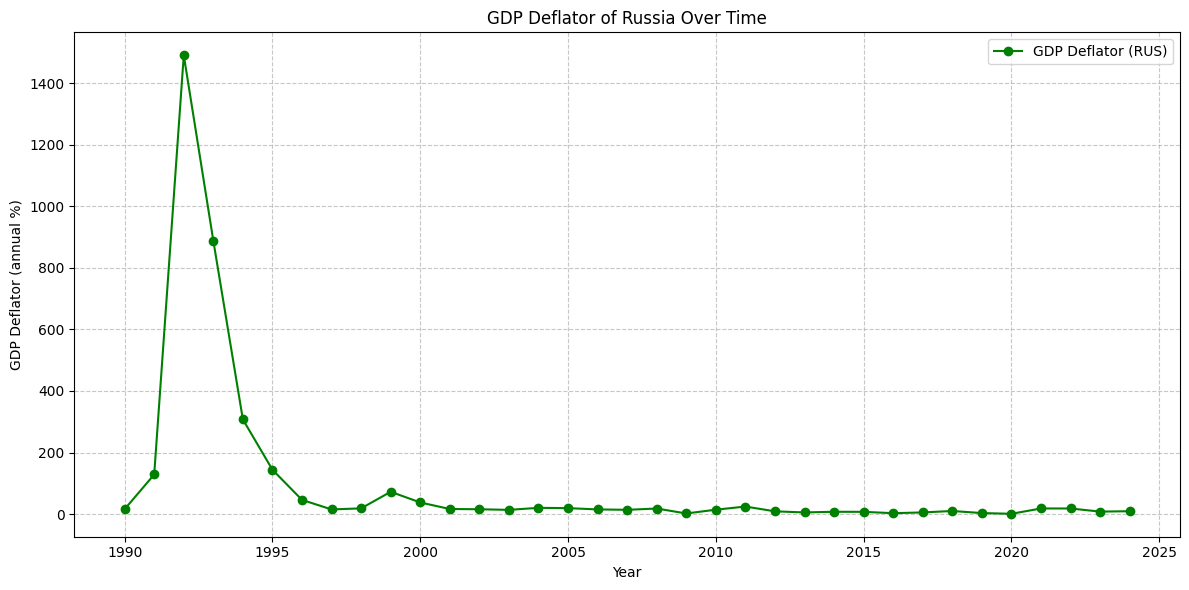

In [35]:
GDP_deflator_RUS_cleaned = GDP_deflator_RUS.dropna(subset=["GDP_deflator"])

# Convert the 'year' column to integer for plotting
GDP_deflator_RUS_cleaned["year"] = GDP_deflator_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    GDP_deflator_RUS_cleaned["year"],
    GDP_deflator_RUS_cleaned["GDP_deflator"],
    marker="o",
    linestyle="-",
    color="green",
    label="GDP Deflator (RUS)"
)


# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("GDP Deflator (annual %)")
plt.title("GDP Deflator of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_39130/2549817777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


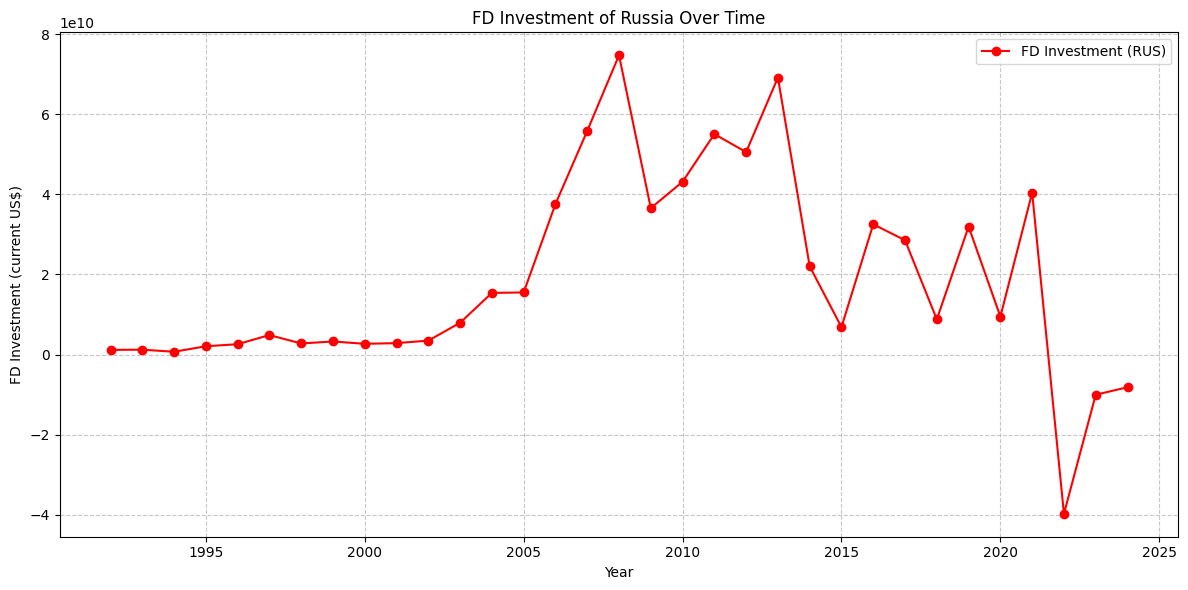

In [36]:
FD_investment_RUS_cleaned = FD_investment_RUS.dropna(subset=["FD_investment"])

# Convert the 'year' column to integer for plotting
FD_investment_RUS_cleaned["year"] = FD_investment_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    FD_investment_RUS_cleaned["year"],
    FD_investment_RUS_cleaned["FD_investment"],
    marker="o",
    linestyle="-",
    color="red",
    label="FD Investment (RUS)"
)


# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("FD Investment (current US$)")
plt.title("FD Investment of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
df = wbdata.get_dataframe(
    indicators,
    countries,                      # 2nd positional argument: list of country codes
    (start_date, end_date),         # 3rd positional argument: tuple for date range

)

KeyboardInterrupt: 

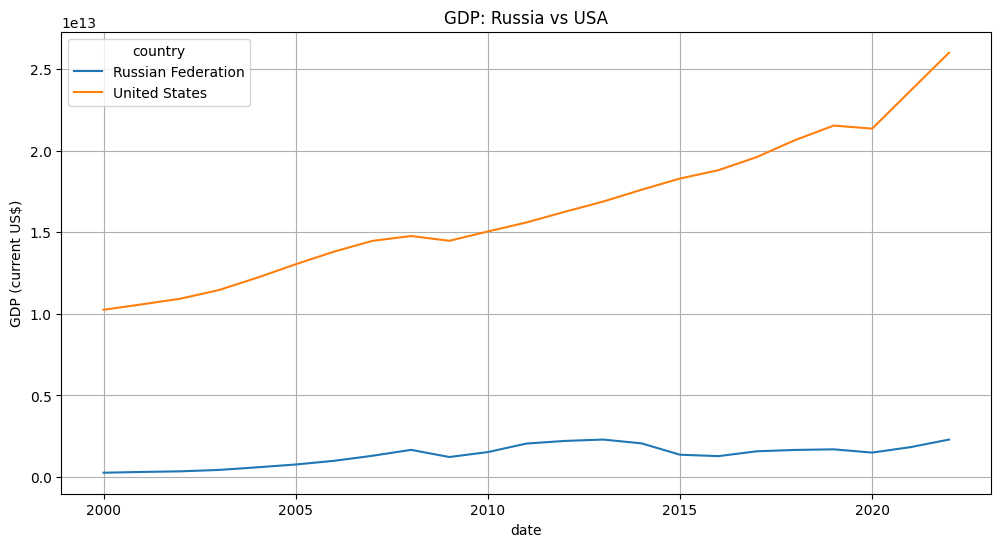

In [40]:
df_pivot = df.reset_index().pivot(index="date", columns="country", values="GDP (current US$)")
df_pivot.plot(figsize=(12,6), title="GDP: Russia vs USA")
plt.ylabel("GDP (current US$)")
plt.grid(True)
plt.show()